In [1]:
# for creating a responsive plot 
%matplotlib widget 

import numpy as np
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt
import pyvista as pv
import math
import vtk
import slicer
import PyQt5


In [2]:
def projection_to_2D(input_tensor: np.array, alpha: float, beta: float, dxc: float, dxd: float) -> np.array:

    #Convert angles to radians:
    alpha = math.radians(alpha)
    beta = math.radians(beta)

    #Projection
    p_base = np.sqrt(1 + np.tan(alpha)**2 + np.tan(beta)**2)
    p_x = -dxc*np.tan(alpha) / p_base
    p_y = dxc / p_base
    p_z = -dxc*np.tan(beta) / p_base
    p = np.array([p_x, p_y, p_z])

    #Axes of X-ray source coordinate system
    z_axis = -p / dxc
    x_axis = np.array([p_y / np.sqrt(p_x**2 + p_y**2), -p_x / np.sqrt(p_x**2 + p_y**2), 0])
    y_base = np.sqrt((p_x**2 + p_y**2)**2 + p_x**2*p_z**2 + p_y**2*p_z**2)
    y_axis = np.array([-p_x*p_z / y_base, -p_x*p_z / y_base, -p_x*p_z / y_base])

    coordinates = []
    for z in range(input_tensor.shape[2]):
        for x in range(input_tensor.shape[0]):
            for y in range(input_tensor.shape[1]):
                if input_tensor[x,y,z] != 0:
                    v_x = x * 0.37695312
                    v_y = y * 0.37695312
                    v_z = z * 0.5

                    #Convert point in volume to point in X-ray source
                    r_x = np.dot(np.array([v_x - p_x, 0, 0]), x_axis)
                    r_y = np.dot(np.array([0, v_y - p_y, 0]), y_axis)
                    r_z = np.dot(np.array([0, 0, v_z - p_z]), z_axis)   #(v_z - p_x) * z_axis
                    # r = (v_x - p_x) * x_axis + (v_y - p_y) * y_axis + (v_z - p_z) * z_axis
                    # r_x = r[0]
                    # r_y = r[1]
                    # r_z = r[2]
                    coordinates.append([r_x * dxd / r_z, r_y * dxd / r_z])

    coordinates = np.array(coordinates)
    coordinates[:,0] -= np.min(coordinates[:,0])
    coordinates[:,1] -= np.min(coordinates[:,1])
    coordinates = coordinates/np.max(coordinates) * 512
    return coordinates


In [4]:
import numpy as np
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt

cta_volume = nib.load('C:\\Users\\nasre\\Downloads\\ImageCAS\\1-200\\1-200\\1.label.nii.gz').get_fdata()
print(cta_volume.shape)

(512, 512, 275)


c:\Users\nasre\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\nasre\AppData\Local\Programs\Python\Python311\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


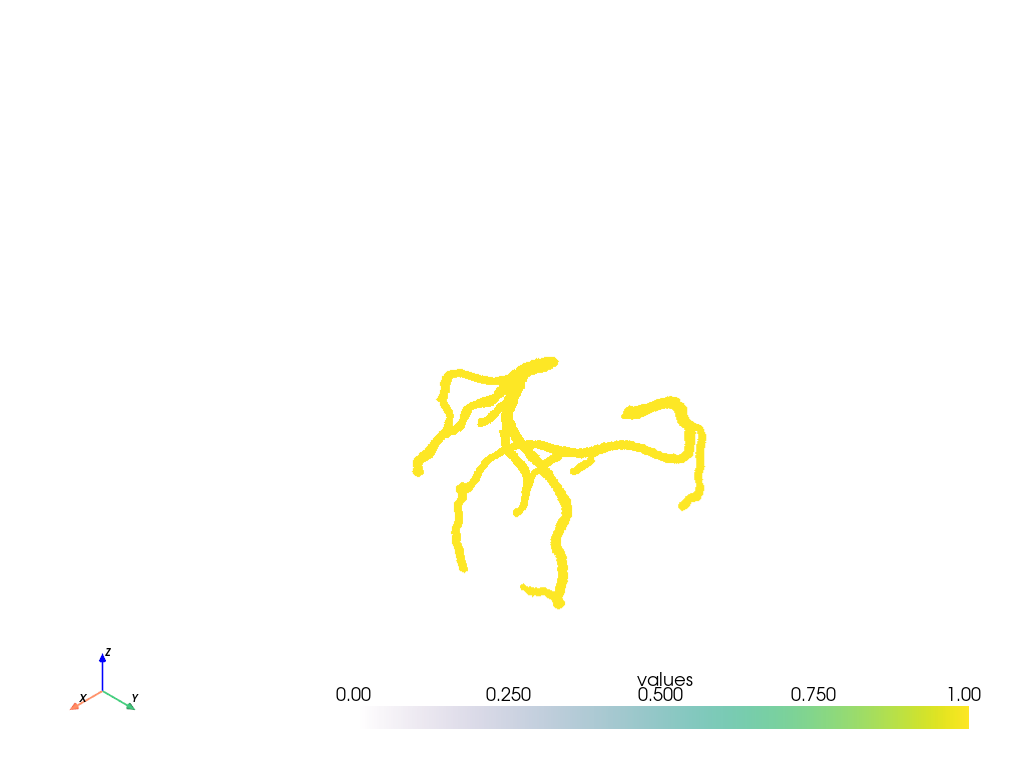

In [5]:
import pyvista as pv

data = pv.wrap(cta_volume)
data.plot(volume=True) # Volume render

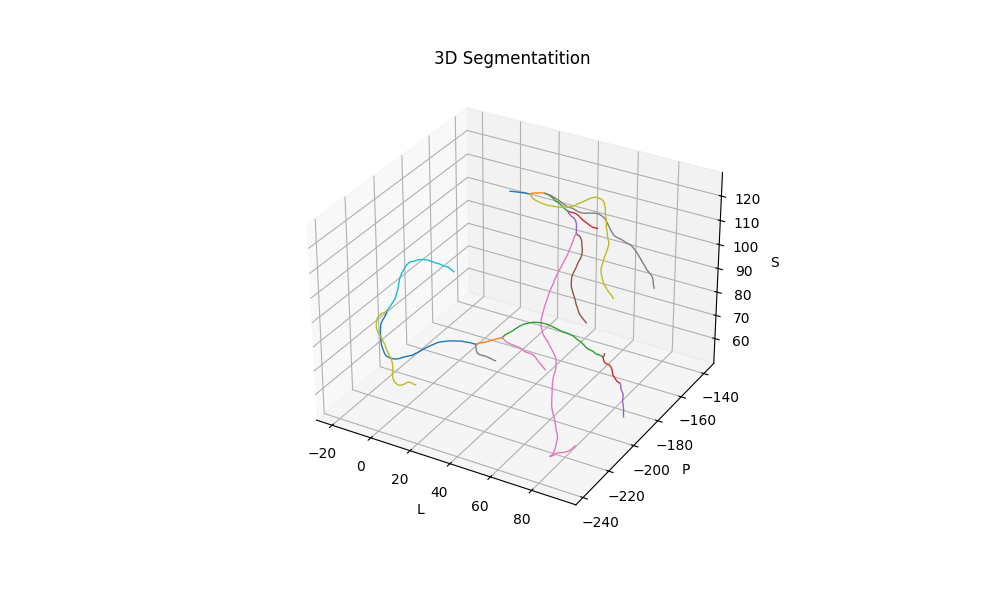

In [24]:

from mpl_toolkits.mplot3d import Axes3D
import glob

directory_path = 'C:\\Users\\nasre\\OneDrive\\Documenten\\MedicalImaging\\Segments_renamed\\Segments_renamed\\'
file_pattern = directory_path + 'SegmentPoints_0001_*.csv'

file_list = glob.glob(file_pattern)


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for idx, file in enumerate(file_list):
    df = pd.read_csv(file)
    
    
    l = df['l']
    p = df['p']
    s = df['s']
    
    
    ax.plot(l, p, s, linestyle='-', linewidth=1)

# Add title and labels
ax.set_title('3D Segmentatition')
ax.set_xlabel('L')
ax.set_ylabel('P')
ax.set_zlabel('S')

# Show the plot
plt.show()


Number of parameters: 2598722


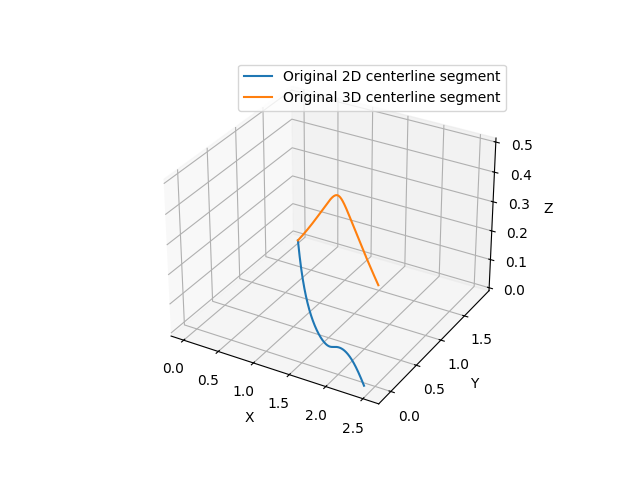

In [7]:
from torch.utils.data import DataLoader
from data_loaders import *
from model import CARNet
from main import mPD_loss_2


# Load the model
model = CARNet().to('cuda')
model.load_state_dict(torch.load("D:\\CTA data\\models\\CAR-Net-256-20.pth"))
loss = mPD_loss_2()

# Load dataset
train_dataset = CenterlineDatasetSpherical(base_dir="D:\\CTA data\\")
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)


device = 'cuda'
# Run model
data_iter = iter(train_loader)
sample = next(data_iter)
sample['origin_3D'].requires_grad_(True)
sample['shape_3D'].requires_grad_(True)
sample['origin_2D'].requires_grad_(True)
sample['shape_2D'].requires_grad_(True)
sample['origin_3D'].retain_grad()
sample['shape_3D'].retain_grad()
sample['origin_2D'].retain_grad()
sample['shape_2D'].retain_grad()
deformation_field = model(sample['origin_3D'].to(device), sample['shape_3D'].to(device), sample['origin_2D'].to(device), sample['shape_2D'].to(device))
deformation_field.requires_grad_(True)
deformation_field.retain_grad()


spherical_3D_deformed = sample['shape_3D'].clone().to('cuda')
spherical_3D_deformed[:, 1:, :] = torch.add(spherical_3D_deformed[:, 1:, :], deformation_field)

# Convert back to cartesian domain
deformed_cart_3D = loss.cartesian_tensor(sample['origin_3D'].to('cuda'), spherical_3D_deformed)
original_cart_3D = loss.cartesian_tensor(sample['origin_3D'].to('cuda'), sample['shape_3D'].to('cuda'))
original_cart_2D = loss.cartesian_tensor(sample['origin_2D'].to('cuda'), sample['shape_2D'].to('cuda'))

deformed_3D = deformed_cart_3D.clone().detach().cpu().numpy()
original_3D = original_cart_3D.clone().detach().cpu().numpy()
original_2D = original_cart_2D.clone().detach().cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

idx = 0

# Extract x, y, z coordinates from the input array
org_x = original_2D[idx, 0, :]
org_y = original_2D[idx, 1, :]
# org_z = original_2D[idx, 2, :]
org_z = np.zeros(original_2D[idx, 2, :].shape) # To prevent the small non-zero values to influence the plot



org_x_3 = original_3D[idx, 0, :]
org_y_3 = original_3D[idx, 1, :]
org_z_3 = original_3D[idx, 2, :]


# Plot the lines connecting the points
ax.plot(org_x, org_y, org_z)
ax.plot(org_x_3, org_y_3, org_z_3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['Original 2D centerline segment', 'Original 3D centerline segment'])
plt.show()

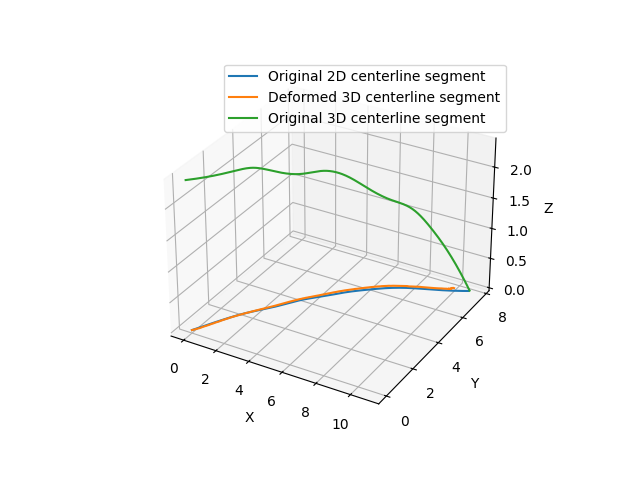

In [8]:

# Load the model
model = CARNet().to('cuda')
model.load_state_dict(torch.load("D:\\CTA data\\models\\CAR-Net-256-20.pth"))
loss = mPD_loss_2()

# Load dataset
train_dataset = CenterlineDatasetSpherical(base_dir="D:\\CTA data\\")
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)


device = 'cuda'
# Run model
data_iter = iter(train_loader)
sample = next(data_iter)
sample['origin_3D'].requires_grad_(True)
sample['shape_3D'].requires_grad_(True)
sample['origin_2D'].requires_grad_(True)
sample['shape_2D'].requires_grad_(True)
sample['origin_3D'].retain_grad()
sample['shape_3D'].retain_grad()
sample['origin_2D'].retain_grad()
sample['shape_2D'].retain_grad()
deformation_field = model(sample['origin_3D'].to(device), sample['shape_3D'].to(device), sample['origin_2D'].to(device), sample['shape_2D'].to(device))
deformation_field.requires_grad_(True)
deformation_field.retain_grad()


spherical_3D_deformed = sample['shape_3D'].clone().to('cuda')
spherical_3D_deformed[:, 1:, :] = torch.add(spherical_3D_deformed[:, 1:, :], deformation_field)

# Convert back to cartesian domain
deformed_cart_3D = loss.cartesian_tensor(sample['origin_3D'].to('cuda'), spherical_3D_deformed)
original_cart_3D = loss.cartesian_tensor(sample['origin_3D'].to('cuda'), sample['shape_3D'].to('cuda'))
original_cart_2D = loss.cartesian_tensor(sample['origin_2D'].to('cuda'), sample['shape_2D'].to('cuda'))

deformed_3D = deformed_cart_3D.clone().detach().cpu().numpy()
original_3D = original_cart_3D.clone().detach().cpu().numpy()
original_2D = original_cart_2D.clone().detach().cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

idx = 0

# Extract x, y, z coordinates from the input array
org_x = original_2D[idx, 0, :]
org_y = original_2D[idx, 1, :]
# org_z = original_2D[idx, 2, :]
org_z = np.zeros(original_2D[idx, 2, :].shape) # To prevent the small non-zero values to influence the plot

def_x = deformed_3D[idx, 0, :]
def_y = deformed_3D[idx, 1, :]
# def_z = deformed_3D[idx, 2, :]
def_z = np.zeros(original_2D[idx, 2, :].shape)

org_x_3 = original_3D[idx, 0, :]
org_y_3 = original_3D[idx, 1, :]
org_z_3 = original_3D[idx, 2, :]


# Plot the lines connecting the points
ax.plot(org_x, org_y, org_z)
ax.plot(def_x, def_y, def_z)
ax.plot(org_x_3, org_y_3, org_z_3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['Original 2D centerline segment', 'Deformed 3D centerline segment', 'Original 3D centerline segment'])
plt.show()